# How the Pandemic Changed Conspiracy Theories on Reddit?
### Sentiment Analysis and Topic Modelling
#### Author: Son N. Nguyen

*Find the project repo [here](https://github.com/nszoni/reddit_conspiracy_theories)*


### Table of Contents

1. [Requirements](#requirements)
2. [Hypothesis](#hypothesis)
3. [Data Collection](#collect)
4. [Data Ingestion](#ingestion)
5. [Data Cleaning](#cleaning)
6. [Text Processing](#processing)
7. [Feature Engineering](#engineering)
8. [Feature Extraction](#extraction)
9. [Exploratory Data Analyis (VADER)](#eda)
10. [Sentiment Analysis](#sentiment)
11. [Entity Analysis](#entity)
12. [Topic Modelling (LDA)](#lda)

## Requirements <a name="requirements"></a>

To make sure you have all the necessary modules installed, I have created a requirements.txt file.

```
pip install -r requirements.txt

```

### Import the required modules:

In [150]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import emoji
import regex

from tqdm import tqdm
from collections import Counter
from datetime import datetime as dt
from wordcloud import WordCloud
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [152]:
#center plot output

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#resize plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

#download vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nszoni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Hypothesis <a name="hypothesis"></a>

My hypothesis is that since the pandemic, there has been more activity and discussions have been more aggressive in the r/conspiracy subreddit. To find that out, my idea was to use VADER sentiment intensity analysis to find out how things have changed in the post-covid world.

Besides, I wanted to see using LDA topic modelling whether topics have been shifted from vaccines, global warming, 5G to other, maybe related to the war, the BLM movement, LGBTQ etc. I believe that there is a trend towards the discussion of human rights and questions revolving around society.

## Data Collection <a name="collect"></a>

### Kaggle

Initially, my plan was to used a dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-conspiracy-theory). It is claimed to be updated daily but the dataset is relatively small. Since there were no external data sources available out of the box, I decided to scrape it myself from the API.

### Scraping Reddit

The traditional way of scraping reddit is to use the API with the PRAW wrapper. However, the API is limited to 1000 requests per hour and is not able to scrape historical data defined by a window. This is not enough for our purposes and our data would be highly unbalanced and biased.

> [PRAW](https://github.com/praw-dev/praw), an acronym for "Python Reddit API Wrapper", is a Python package that allows for simple access to Reddit's API.

#### Overcoming limitations of the Reddit API with Pushift API

Luckily there is a service which allows us to scrape historical data from Reddit. The service is called [Pushift API](https://github.com/pushshift/api). Briefly, it let's us control the scraping window. The python wrapper of the API is called PSAW, but there is also a multi-threaded version called PMAW which is more efficient in high volumes close to hundreds of thousands of records.

> “Pushshift makes it much easier for researchers to query and retrieve historical Reddit data, provides extended functionality by providing fulltext search against comments and submissions, and has larger single query limits.” PSAW, meanwhile, makes it easier to work with Pushshift and provides better documentation."

#### Scraping process

I have used a methodology which blends together the usage of the classical PRAW and PSAW. With PSAW, we only get unique idenfiers of submissions from the API bounded by time, which then we feed it to PRAW's submission endpoint. This way, we can get more features offered by PRAW but overcome its limitation of scraping historical data. For a more detailed reference check out this blogpost [here](https://towardsdatascience.com/how-to-collect-a-reddit-dataset-c369de539114).

The script used for scraping can be found in the project's root directory under the name `reddit_pushift_scraper.py`.

## Data Ingestion <a name="ingestion"></a>

I have scraped **2500 submissions between 2018 and 2019** for the analysis of conspiracy theories and subreddit activity. For comparison, I also got submission-level data between **2021 and 2022** which should be the baseline for the aftermath of the global pandemic.

The dataset consists the following columns:
- **id:** unique identifier of the submission
- **author:** author of the submission
- **url:** url of the submission
- **title:** title of the submission
- **score:** number of upvotes
- **created:** UNIX timestamp of the submission
- **body:** body text of the submission

### Pre-covid conspiracy posts between 2018 and 2019

In [153]:
rc_precovid = pd.read_csv('../data/reddit_ct_pushift_2018_2019.csv')
rc_precovid.head()

,id,author,url,title,score,num_comments,created,body
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted]
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed]
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ..."
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...


### Post-covid top conspiracy post between 2021 and 2022

In [154]:
rc_postcovid = pd.read_csv('../data/reddit_ct_pushift_2021_2022.csv')
rc_postcovid.head()

,id,author,url,title,score,num_comments,created,body
0,ua5ej6,EurekaStockade,https://www.reddit.com/r/conspiracy/comments/u...,"Nuclear Energy--""too cheap to meter""--thats wh...",1,1,1.650720e+09,Before WW2--Globalists realized that cheap nuc...
1,ua58qr,MSA966,https://www.reddit.com/r/conspiracy/comments/u...,Why iPhone face recognition works even though ...,1,2,1.650720e+09,NaN
2,ua55yb,Ancient-Soup2098,https://www.reddit.com/r/conspiracy/comments/u...,Do you think we are the virus?,2,3,1.650720e+09,I’m not necessarily religious/spiritual but I ...
3,ua53xn,jomtienislife,https://youtu.be/DvzqTvafVu0,Russian Ministry of Defense warns of planned p...,0,2,1.650719e+09,NaN
4,ua502a,Mouse1701,https://www.reddit.com/r/conspiracy/comments/u...,Disney world just lost it's government status,4,8,1.650719e+09,Walt Disney world has just lost it's ablilty t...


## Data Cleaning <a name="cleaning"></a>

First, I wanted to label each dataset before concatenating them to segment by the pre-coviid and post-covid data in later analyses. The creation date was given in UNIX time in the raw data which had to be converted into a human-readable format.

In [155]:
# Label dataframes and union

rc_precovid['label'] = 'precovid'
rc_postcovid['label'] = 'postcovid'

rc = pd.concat([rc_precovid, rc_postcovid], axis=0)
rc['timestamp'] = rc['created'].apply(dt.fromtimestamp)

rc.head()

,id,author,url,title,score,num_comments,created,body,label,timestamp
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted],precovid,2019-12-30 23:38:29
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed],precovid,2019-12-30 23:37:08
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ...",precovid,2019-12-30 23:36:27
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN,precovid,2019-12-30 23:32:52
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...,precovid,2019-12-30 23:24:35


In [156]:
# replace [deleted] or [removed] with empty string so that it does not break the next step
rc['body'] = rc['body'].replace('[deleted]', np.nan)
rc['body'] = rc['body'].replace('[removed]', np.nan)

#### Glue together title and body of a submission

We could either do the analysis separately for post titles and body texts, but it would mean that we lose significant amount of data due to fanning through post which only have a title.

As a result, I have decided to keep the analysis concise and concatenate together the two features. The limitation of this manouver is that there are cases where the titles are just the first line of the body text.

In [157]:
# Concat together title and body text
rc['text'] = rc['title'].fillna('') + ' ' + rc['body'].fillna('')

In [158]:
#drop unnecessary columns
rc.drop(['id', 'url', 'created', 'body', 'title'], axis=1, inplace=True)

rc.head()

,author,score,num_comments,label,timestamp,text
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...


In [159]:
# observe missing values in text column
rc['text'].isna().sum()

0

In [160]:
# find values with only spaces
rc[rc['text'].str.strip().str.len() == 0]

,author,score,num_comments,label,timestamp,text


No missing values or whitespaces in our data!

We have in total 5000 submissions.

In [161]:
rc.shape

(5000, 6)

## Text Processing <a name="processing"></a>

#### Extend stopwords corpus

The nltk stopwords corpus is a list of words that are considered irrelevant in the context of text analysis. However, it is not sufficient to remove all irrelevant words from the text as per context. I have arbitarily extended the stopword corpus with words which does not add to the meaning of the text.

In [162]:
#add words to stopword list
stop_words = stopwords.words('english')
stop_words.extend(['use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'one', 'many', 'well', 'two', 'say', 'would', 'make', 'get', 'go', 'thing', 'much'])

I have wrote a text processer function which cleans the text from noises (e.g. username handlers, hyperlinks, non-alphabetic elements, whitespaces, etc.) as well as tokenizes the text, removes stopwords and lemmatizes the generated tokens.

In [163]:
lemmatizer = WordNetLemmatizer()

def text_preprocess_lemmatize(text: str) -> str:
    
    '''
    - remove handlers (eg. @username)
    - remove urls
    - remove any non-word elements (inc. punctuation)
    - remove single letters
    - remove digits
    - replace multiple spaces with a single space
    - tokenize text
    - filter out stopwords
    - lemmatize tokens
    - filter out tokens with less than 3 characters
    '''
    garbage = re.compile('@[^\s]+|http\S+|\W|\s+[a-zA-Z]\s+|\d+|\s+')
    
    text = text.lower()
    text= re.sub(garbage,' ', text)
    
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stop_words)]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

Applying the text processer, we can see that it did a good job in overall

In [164]:
rc['cleaned'] = rc['text'].apply(text_preprocess_lemmatize)

In [165]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...


## Feature Engineering <a name="engineering"></a>

For feature, engineering, we need to generate polarity scores for the submissions. I did that with the help of the VADER lexicon which is suitable for categorizing social media texts with emoticons. I did not apply the sentiment intensity analysis algorithm on the cleaner, lemmatized data, rather used it on the raw text data after filtering out non-alphabetic characters and lowercasing them.

> [VADER](https://github.com/cjhutto/vaderSentiment) is a lexicon and rule-based feeling analysis instrument that is explicitly sensitive to suppositions communicated in web-based media. VADER utilizes a mix of lexical highlights (e.g., words) that are, for the most part, marked by their semantic direction as one or the other positive or negative. Thus, VADER not only tells about the Polarity score yet, in addition, it tells us concerning how positive or negative a conclusion is.

In [166]:
# Apply SIA from Vader package
sid = sia()

# lowercase and remove all non-alphabetic elements and fit polarity scores
rc['sentiments'] = rc['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [167]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp..."
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co..."
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp..."


Parse out elements of the dictionary to columns

In [168]:
# Parse out dict elements

rc['positive'] = rc['sentiments'].apply(lambda x: x['pos']) 
rc['neutral'] = rc['sentiments'].apply(lambda x: x['neu'])
rc['negative'] = rc['sentiments'].apply(lambda x: x['neg'])
rc['compound'] = rc['sentiments'].apply(lambda x: x['compound'])

In [169]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341


Based on my online research in determining a compund threshold, I will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

All in-between will be considered as a neutral text.

In [170]:
THRESHOLD = 0.2

conditions = [
    (rc['compound'] <= -THRESHOLD),
    (rc['compound'] > -THRESHOLD) & (rc['compound'] < THRESHOLD),
    (rc['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
rc['sentiment'] = np.select(conditions, values)

In [171]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500,neg
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963,pos
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341,neg


## Feature Extraction <a name="extraction"></a>

### Naive features

Let's carve out some naive metrics like the number of words, stopwords, the average word lenght, and the number of question marks.

In [183]:
rc['num_words'] = rc['text'].apply(lambda x: len(x.split(' ')))
rc['num_stopwords'] = rc['text'].apply(lambda x: len([word for word in x.split(' ') if word in list(stop_words)]))
rc['avg_word_length'] = rc['text'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(stop_words)])))
rc['num_question_mark'] = rc['text'].apply(lambda x: len([va for va in x.split(' ') if va == '?']))
rc['year']  = pd.DatetimeIndex(rc['timestamp']).year
rc['month'] = pd.DatetimeIndex(rc['timestamp']).month

### Emoji features

When analyzing social media data, we cannot skip past the fact that there is a trend towards people expressing themselves through emojis. 

My intention here was to prepare the dataset for analyzing the commonly used emojis across multiple segments (time or sentiment), therefore I have collected all the emojis a submission to a list and added a counter for each.

In [173]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [174]:
#apply split count to column text
rc['emoji_list'] = rc['text'].apply(split_count)

In [175]:
rc['num_emojis'] = rc['emoji_list'].apply(len)

In [176]:
rc[rc['num_emojis'] > 5].head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length,num_question_mark,emoji_list,num_emojis
463,elisa_bp101,0,10,postcovid,2022-04-22 18:34:54,JESUS CHRIST is an Alien God that's why he Res...,jesus christ alien god resurrected dead real t...,"{'neg': 0.092, 'neu': 0.774, 'pos': 0.134, 'co...",0.134,0.774,0.092,0.8372,pos,397,168,6.069869,0,"[🛡️, 🙄, 😉, 🛸, 🌎, 🕳️, 🌀, 🚽]",8
987,Hedggiekilla419,11,5,postcovid,2022-04-21 20:08:59,"Regardless of what 💩 MSM is pushing, inflation...",regardless msm pushing inflation caused russia...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu,26,9,6.000000,0,"[💩, 💯, 🤦, 🖍️, 🍌, 🦧, 🚀, 🌚, 💯]",9
1615,arnott,7,7,postcovid,2022-04-20 16:34:59,BCG 💩 Victoria’s Secret 👙 Jeffrey Epstein 🧟 Ke...,bcg victoria secret jeffrey epstein kenneth gr...,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",0.000,0.916,0.084,-0.2960,neg,33,8,4.240000,0,"[💩, 👙, 🧟, 🏰, 🧶, 🕸]",6


## Exploratory Data Analysis <a name="eda"></a>

### Distributions

### Do people write lenghtier posts after COVID?

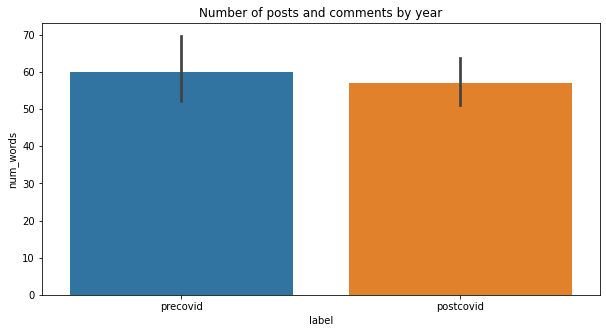

In [177]:
sns.barplot(x='label', y='num_words', data=rc)
plt.title('Number of posts and comments by year')
plt.show()

### Distribution of sentiment categories

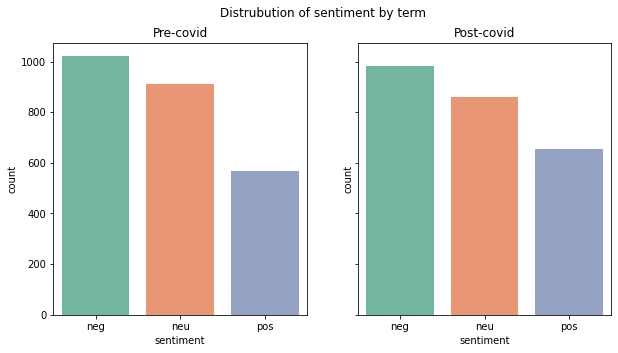

In [179]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Distrubution of sentiment by term')

# Pre-covid
sns.countplot(ax=axes[0], x='sentiment', data=rc[rc['label']=='precovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[0].set_title('Pre-covid')

# Post-covid
sns.countplot(ax=axes[1], x='sentiment', data=rc[rc['label']=='postcovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[1].set_title('Post-covid')

plt.show()

Text(0.5, 1.0, 'Negative')

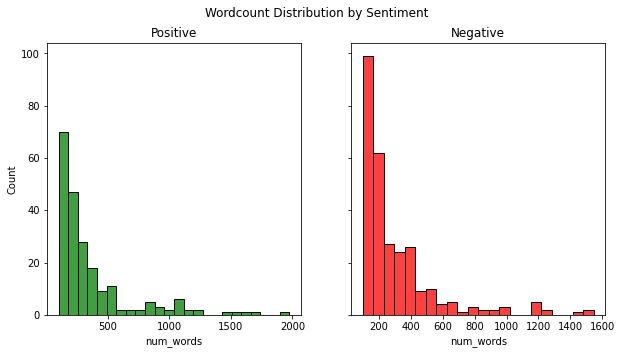

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Wordcount Distribution by Sentiment')


sns.histplot(rc[(rc['sentiment']=='pos') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[0],color='green')
axes[0].set_title('Positive')

sns.histplot(rc[(rc['sentiment']=='neg') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[1],color='red')
axes[1].set_title('Negative')

### Emoticon analysis

#### Positive emojis

In [184]:
# generate emoji frequencies for positive posts
pos_counter = Counter()
for item in rc[rc['sentiment'] == 'pos']['emoji_list']:
    pos_counter.update(item)

pos_emojis = pd.DataFrame.from_dict(pos_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

pos_plot = pos_emojis.nlargest(5, 'count')

#### Negative emojis

In [185]:
# generate emoji frequencies for negative posts
neg_counter = Counter()
for item in rc[rc['sentiment'] == 'neg']['emoji_list']:
    neg_counter.update(item)

neg_emojis = pd.DataFrame.from_dict(neg_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

neg_plot = neg_emojis.nlargest(5, 'count')

### Commonly used emojis per sentiment

In [186]:
fig = make_subplots(rows=2, cols=1,
    subplot_titles=("Positive", "Negative"))

fig.add_trace(go.Scatter(y=pos_plot['emoji'],
                x=pos_plot['count'],
                name='Positive Emojis',
                marker_color='white',
                orientation='h',
                text=pos_plot['emoji'],
                textposition='top center',
                mode='markers+text',
                textfont=dict(size=30),
                ), row=1, col=1)

fig.add_trace(go.Scatter(y=neg_plot['emoji'],
                x=neg_plot['count'],
                name='Negative Emojis',
                marker_color='white',
                orientation='h',
                text=neg_plot['emoji'],
                textposition='top center',
                mode='markers+text',
                textfont=dict(size=30),
                ), row=2, col=1)

fig.update_yaxes(visible =False, range=[0, len(pos_plot)+1])
fig.update_xaxes(title='# Usage')

fig.update_layout(height=800, width=800, title_text="Emojis per Sentiment", template='simple_white')
fig.show()

## Sentiment Analysis <a name="sentiment"></a>

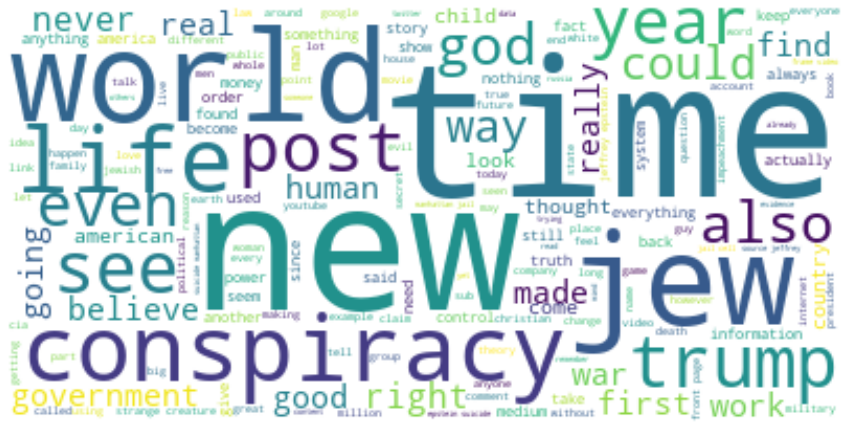

In [187]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
precovid_wc = rc[rc['label'] == 'precovid']
words = ''
for sentence in precovid_wc['cleaned']:
    words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

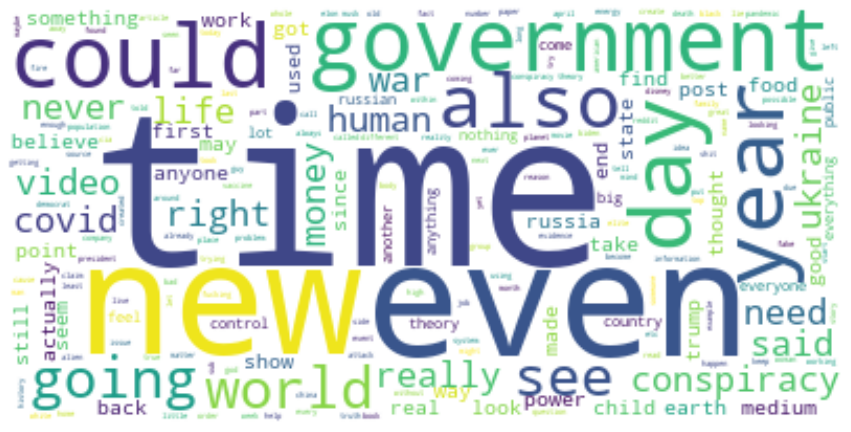

In [188]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
postcovid_wc = rc[rc['label'] == 'postcovid']
words = ''
for sentence in postcovid_wc['cleaned']:
    words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

### Visualize positive and negative words 

## Entity Analyis <a name="entity"></a>

In [189]:
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(rc['cleaned'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

<AxesSubplot:xlabel='frequency', ylabel='bigram/trigram'>

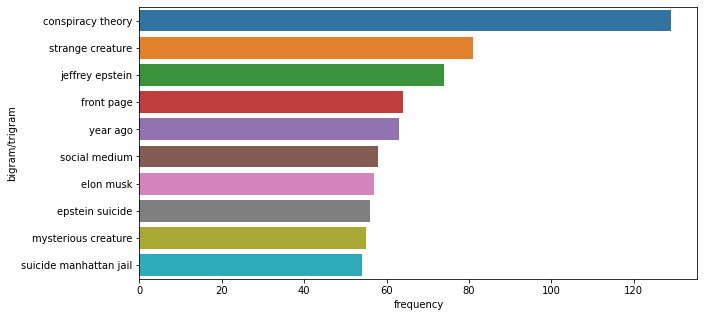

In [190]:
# seaborn barplot top 10 bigrams
sns.barplot(y='bigram/trigram', x='frequency', data=df_ngram.nlargest(10, 'frequency'))

## Topic Modelling (LDA) <a name="lda"></a>

In [191]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

corpus = [x.split() for x in rc['cleaned']]

# Create Dictionary 
id2word = corpora.Dictionary(corpus) 

# Convert to bag of words
doc_term = [id2word.doc2bow(text) for text in corpus] 

In [192]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [193]:
print(lda_model.print_topics(num_topics=10, num_words=3))

[(0, '0.007*"time" + 0.006*"even" + 0.005*"year"'), (1, '0.019*"god" + 0.015*"vaccine" + 0.012*"life"'), (2, '0.015*"conspiracy" + 0.010*"war" + 0.008*"right"'), (3, '0.041*"video" + 0.021*"creature" + 0.019*"alien"'), (4, '0.018*"vaccinated" + 0.013*"ritual" + 0.011*"fauci"'), (5, '0.030*"jew" + 0.010*"cnn" + 0.009*"jewish"'), (6, '0.010*"dark" + 0.009*"black" + 0.008*"energy"'), (7, '0.019*"reddit" + 0.018*"killed" + 0.013*"watch"'), (8, '0.010*"year" + 0.009*"government" + 0.008*"new"'), (9, '0.010*"human" + 0.008*"man" + 0.007*"paper"')]


In [195]:
#ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#plot topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.251411 -0.007902       1        1  29.017360
2     -0.232774 -0.081177       2        1  22.744755
8     -0.182670 -0.023498       3        1  18.274499
1     -0.044569  0.201292       4        1   7.606308
6      0.036630  0.088561       5        1   5.633573
3      0.090394 -0.231389       6        1   4.831730
9      0.099442  0.112143       7        1   4.014598
7      0.166622 -0.065285       8        1   3.833337
5      0.154908 -0.001084       9        1   2.967512
4      0.163429  0.008339      10        1   1.076328, topic_info=            Term        Freq       Total Category  logprob  loglift
887        video  293.000000  293.000000  Default  30.0000  30.0000
353   conspiracy  571.000000  571.000000  Default  29.0000  29.0000
507          god  221.000000  221.000000  Default  28.0000  28.0000
719         post  298.000000  298.000000  Default  27.0000  27.0000
4820     vaccine  210.000000  210.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
4517     lawsuit    7.311367   15.623625  Topic10  -5.3654   3.7723
2304    facebook   10.179153   41.070228  Topic10  -5.0345   3.1367
881        kevin    5.866416   14.527108  Topic10  -5.5856   3.6248
715         news   11.958575  190.041809  Topic10  -4.8734   1.7658
617    interview    5.397390   54.870828  Topic10  -5.6689   2.2125

[595 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3984       1  0.991533  academic
949        1  0.070291   account
949        2  0.291205   account
949        3  0.130540   account
949        6  0.411704   account
...      ...       ...       ...
9938       3  0.974793  zelensky
2306       1  0.989684      zero
3250       9  0.942498   zionist
13570      9  0.921271       𝖢𝖭𝖭
13716      9  0.921271     𝖳𝗋𝗎𝗆𝗉

[1091 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 9, 2, 7, 4, 10, 8, 6, 5])